In [12]:
!pip install --upgrade pip --quiet
!pip install cvxopt --quiet


[notice] A new release of pip is available: 22.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [1]:
#import some useful packages
import numpy as np
import matplotlib.pyplot as plt
from qiskit import IBMQ, schedule
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit import Gate, Parameter, QuantumCircuit
from qiskit import pulse, schedule
from qiskit.tools.jupyter import *
from qiskit_ibm_provider.job import job_monitor
from qiskit.pulse import Gaussian
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%config InlineBackend.figure_formats = ['svg']
import time
import os
import csv
from scipy.optimize import curve_fit


import warnings
warnings.filterwarnings('ignore')

import time
import os
import csv

In [18]:
# IBMQ.save_account('c28063071324a27bf0f536ec2d6c376b146467db302e3b3039204d028f1ecdd776dea90d6c104302c8b2808d51786c51948e360d6b6c19d7b74a45b0da2e2671')
provider = IBMQ.load_account()

# provider = IBMProvider()
backend = provider.get_backend('ibm_brisbane')

ibmqfactory.load_account:WARNING:2023-12-26 09:09:05,443: Credentials are already in use. The existing account in the session will be replaced.


In [7]:
qubit = 0
pi = np.pi
cos = np.cos
sin = np.sin
NUM_SHOTS = 20000
scale_factor = 1e-7

In [9]:
def Z01(phi):
    return np.array([[np.exp(-1j * phi), 0, 0],
                     [0, 1, 0],
                     [0, 0, 1]])

def Z12(phi):
    return np.array([[1, 0, 0],
                     [0, 1, 0],
                     [0, 0, np.exp(1j * phi)]])

def X01(theta):
    return np.array([[np.cos(theta / 2), -1j * np.sin(theta / 2), 0],
                     [-1j * np.sin(theta / 2), np.cos(theta / 2), 0],
                     [0, 0, 1]])


def X12(theta):
    return np.array([[1, 0, 0],
                     [0, np.cos(theta / 2), -1j * np.sin(theta / 2)],
                     [0, -1j * np.sin(theta / 2), np.cos(theta / 2)]])

def R01(theta, phi, alpha):
  R01_theory = Z01(phi) @ X01(theta) @ Z01(-phi)
  return Z12(alpha) @ R01_theory

def R12(theta, phi, beta, gamma):
  R12_theory = Z12(phi) @ X12(theta) @ Z12(-phi)
  return Z12(gamma) @ Z01(beta) @ R12_theory

def population_model(phi, alpha, beta, gamma):
    ground = np.array([[1], [0], [0]])
    psi =  Z12(alpha) @ Z01(-phi + beta) @ X12(np.pi/2) @ Z01(phi + gamma) @ ground
    return [np.abs(psi[0][0])**2, np.abs(psi[1][0])**2, np.abs(psi[2][0])**2]

def loss_func(param, phi, p_exp, N_data = 97):
  p_model = [population_model(phi[i], *param, order) for i in range(N_data)]
  return mean_squared_error(p_model, p_exp, squared = False)

In [13]:
#some useful function
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data.
    """
    job_results = job.result()  # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average:  # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
        else:  # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

#define a pulse rotating theta around n-axis in subspace 0-1 and 1-2

def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i] = [np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

def discriminate(data) :
    zero_data = data[0]
    one_data = data[1]
    two_data = data[2]
    zero_data_reshaped = reshape_complex_vec(zero_data)
    one_data_reshaped = reshape_complex_vec(one_data)
    two_data_reshaped = reshape_complex_vec(two_data)
    IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
    state_012 = np.zeros(NUM_SHOTS)  
    state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
    state_012 = np.concatenate((state_012, 2 * np.ones(NUM_SHOTS)))
    IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.3)
    LDA_012 = LinearDiscriminantAnalysis()
    LDA_012.fit(IQ_012_train, state_012_train)
    return LDA_012

def count(data, discriminator):
    sched_data = []
    for i in range(len(data)):
        sched_data.append(reshape_complex_vec(data[i]))
    discrim_data = []
    for j in range(len(sched_data)):
        discrim_data.append(discriminator.predict(sched_data[j]))
        #print('predicting', j, end='\r')
    final_result = []
    for k in range(len(discrim_data)):
        result = {'0': 0, '1': 0, '2': 0}
        for l in range(len(discrim_data[k])):
            if discrim_data[k][l] == 0.0:
                result['0'] += 1
            elif discrim_data[k][l] == 1.0:
                result['1'] += 1
            elif discrim_data[k][l] == 2.0:
                result['2'] += 1
            else:
                print('Unexpected behavior')
        final_result.append(result)
    return final_result

from cvxopt import matrix, solvers
def mitigated_population(p, C):
    P = matrix(np.transpose(C).dot(C))
    q = matrix(-np.transpose(p).dot(C))
    G = matrix([[-1.0,0.0,0.0],[0.0,-1.0,0.0],[0.0,0.0,-1.0]])
    h = matrix([0.0, 0.0, 0.0])
    A = matrix([1.0, 1.0, 1.0], (1,3))
    b = matrix(1.0)
    solvers.options['show_progress'] = False
    sol=solvers.qp(P, q, G, h, A, b)
    # return np.asarray(sol['x'])
    return np.array([e for e in sol['x']])

def get_population(data, discriminator):
    drag_values = count(data, discriminator)
    return np.asarray([[val['0']/NUM_SHOTS, val['1']/NUM_SHOTS, val['2']/NUM_SHOTS] for val in drag_values])

def get_mitigated_population(data, discriminator, confusion_matrix):
    population = get_population(data, discriminator)
    mitigated = [mitigated_population(pop, confusion_matrix) for pop in population]
    return np.asarray(mitigated)



#l

# Data processing

In [14]:
def IQ_012_plot(discrim_data):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    zero_data = discrim_data[0]
    one_data = discrim_data[1]
    two_data = discrim_data[2]
    alpha = 1
    size = 10
    plt.scatter(np.real(zero_data), np.imag(zero_data),
                s=size, cmap='viridis', c='blue', alpha=alpha, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data),
                s=size, cmap='viridis', c='red', alpha=alpha, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data),
                s=size, cmap='viridis', c='green', alpha=alpha, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    mean_alpha = 1
    mean_size = 100
    plt.scatter(np.real(mean_zero), np.imag(mean_zero),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_one), np.imag(mean_one),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_two), np.imag(mean_two),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)

    plt.legend(fontsize=15)
    plt.grid()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

In [16]:
from scipy.optimize import minimize

def phase_tracking(job_id):
    job = provider.backend.retrieve_job(job_id)
    data = get_job_data(job, average = False)
    discrim_data = data[:3]
    exp_data = data[3:]
    
    IQ_012_plot(discrim_data)
    
    LDA_012 = discriminate(discrim_data)

    discr_data = count(discrim_data, LDA_012)
    #confusion matrix
    conf_mat = [[discr_data[i]['0'] / NUM_SHOTS, discr_data[i]['1'] / NUM_SHOTS, discr_data[i]['2'] / NUM_SHOTS] for i in
                    range(np.shape(discr_data)[0])] 
    
    population = get_mitigated_population(exp_data, LDA_012, conf_mat)

    N_seed = 100
    N_data = 97
    loss = 200
    x_optimum = 0
    phi_arr = np.linspace(0, np.pi, 97)
    for i in range(N_seed):
        # print(i)
        x_initial = np.random.default_rng().uniform(-np.pi/10, np.pi/10, 3)
        # eps = 0.15
        # x_initial = [np.random.default_rng().uniform(-np.pi/4 - eps, -np.pi/4 + eps), np.random.default_rng().uniform(-eps, eps), np.random.default_rng().uniform(np.pi/4 - eps, np.pi/4 + eps)]
        res = minimize(loss_func, x0 = x_initial, args = (phi_arr, population, order))
        if(res.fun < loss):
            loss = res.fun
            x_optimum = res.x%(2*pi)

    N_data = 97
    param = np.array(x_optimum)
    model_population = [population_model(phi[i], *param, order)  for i in range(N_data)]

    fig, axs = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(13, 5), dpi=100)
    plt.setp(axs.flat, aspect=1.0, adjustable='box')
    plt.subplots_adjust(top=1, hspace=0)
    fig.tight_layout()
    plt.suptitle(str(x_optimum), weight = 'bold')
    colors = ['r', 'g', 'b']
    r2_arr = []
    for i in range(3):
        p_model = [p[i] for p in model_population]
        p_exp = [p[i] for p in population]
        r2_arr.append(np.round(r2_score(p_model, p_exp), 3))
        axs[i].scatter(p_model, p_exp, color = colors[i])
        xplt = np.linspace(0, 1, 1000)
        axs[i].plot(xplt, xplt, color = 'black')
        axs[i].axis(xmin = 0, xmax = 1, ymin = 0, ymax = 1)
        axs[i].set_title('r^2 = ' + str(np.round(r2_score(p_model, p_exp), 3)) )
    return x_optimum, r2_arr, loss

In [17]:
phase_tracking('cp59b7cyx18g008as4bg')

Traceback (most recent call last):
  Cell In[17], line 1
    phase_tracking('cp59b7cyx18g008as4bg')
  Cell In[16], line 4 in phase_tracking
    job = provider.backend.retrieve_job(job_id)
  File /opt/conda/lib/python3.10/site-packages/qiskit/providers/ibmq/ibmqbackendservice.py:652 in retrieve_job
    raise IBMQBackendApiError('Failed to get job {}: {}'
IBMQBackendApiError: "Failed to get job cp59b7cyx18g008as4bg: '404 Client Error: Not Found for url: https://api.quantum.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/Jobs/cp59b7cyx18g008as4bg/v/1. Job not found., Error code: 3250.'"

Use %tb to get the full traceback.


In [14]:
res[1]

[0.959, -0.166, -0.03]

In [9]:
from numpy import loadtxt
dd = 18
mm = 8
yy = 2023
folder = f"{yy}_{mm}_{dd}"
job_id_file = f"./{folder}/job_id_0_{yy}_{mm}_{dd}_lagos.txt"
order_file = f"./{folder}/order_0_{yy}_{mm}_{dd}_lagos.txt"
job_id_arr = np.genfromtxt(job_id_file,dtype='str')
order_arr = np.genfromtxt(order_file,dtype='str')


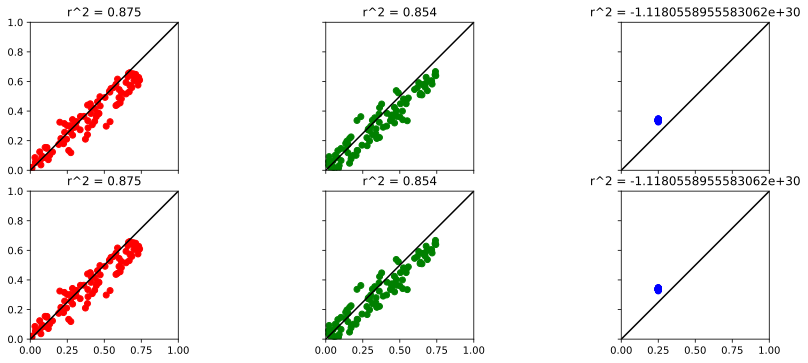

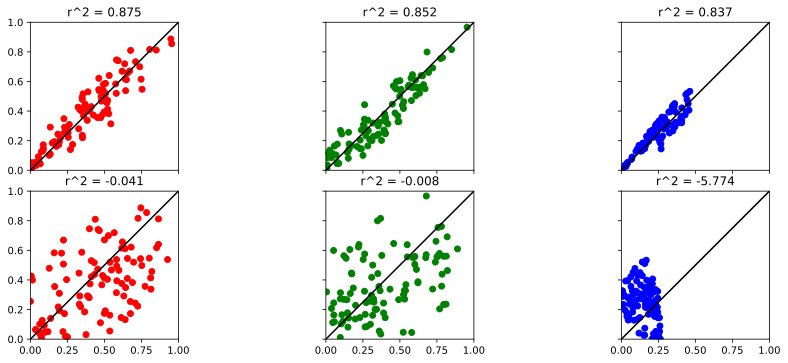

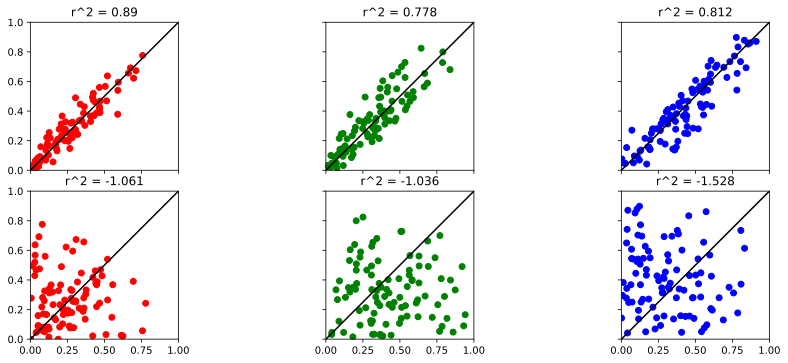

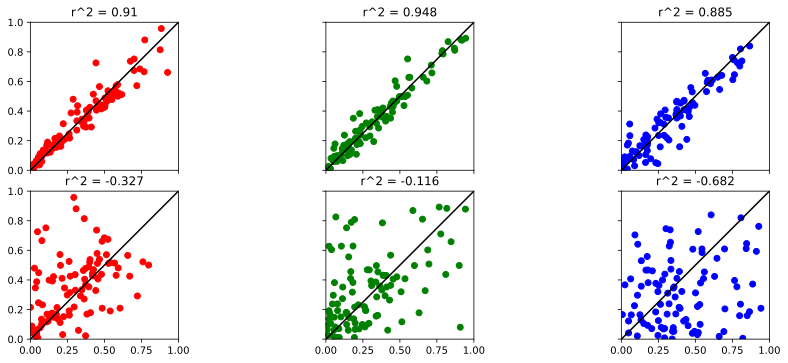

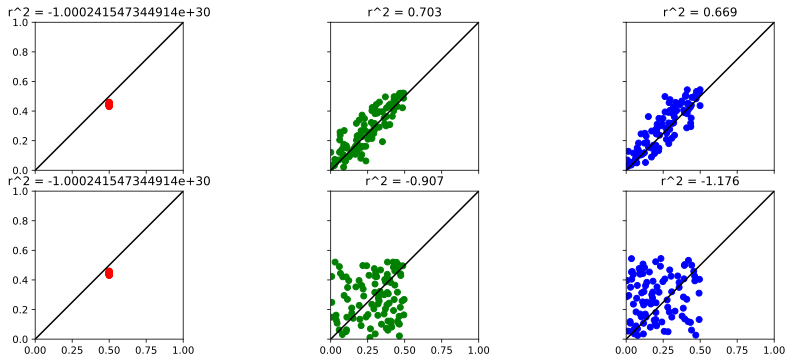

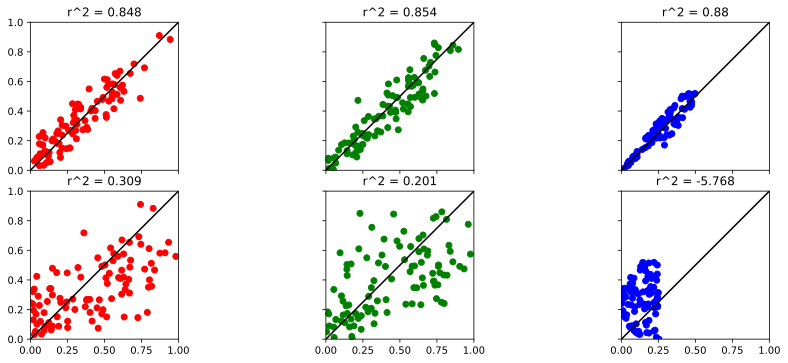

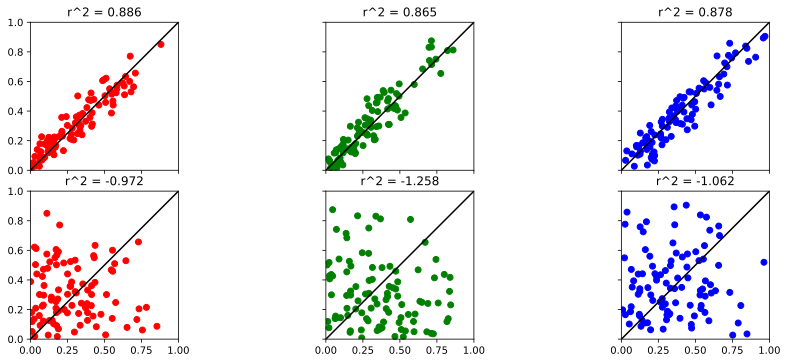

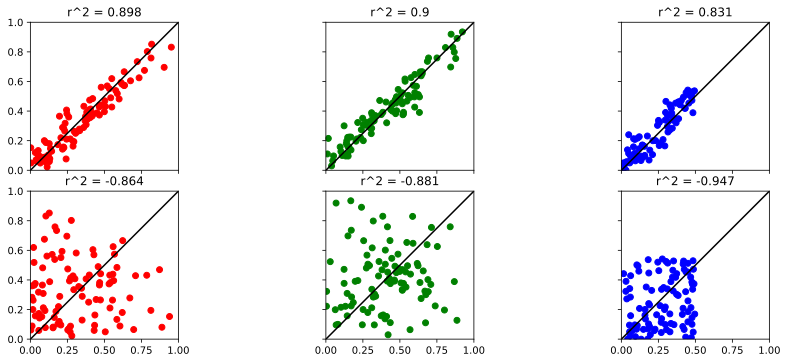

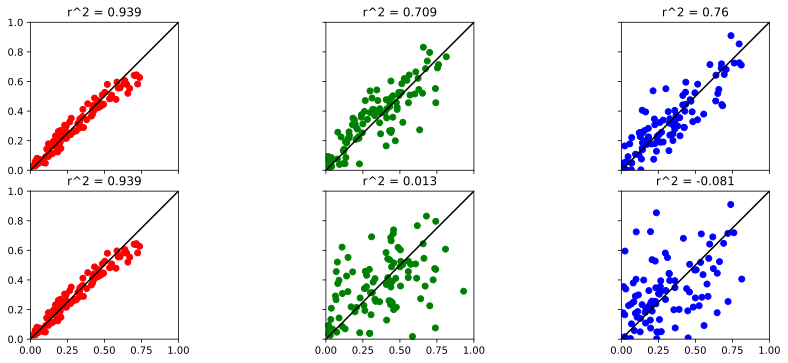

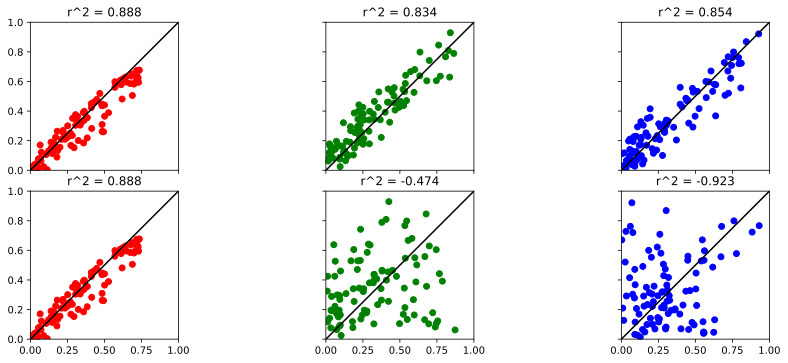

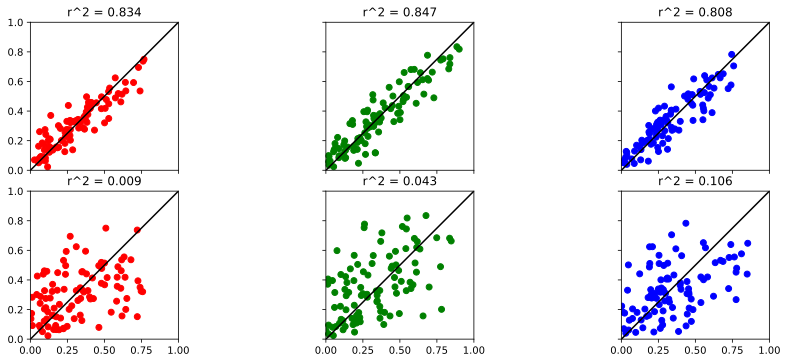

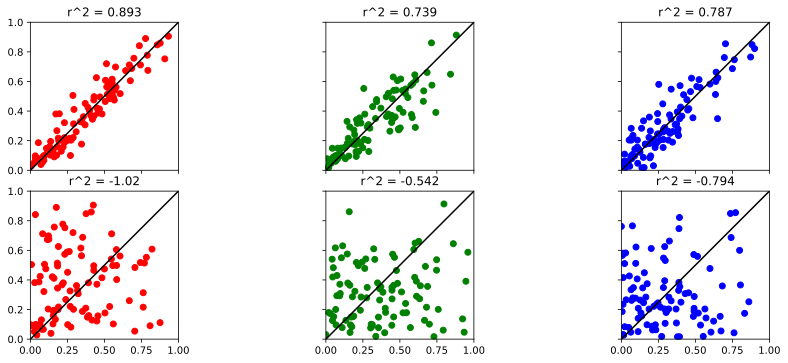

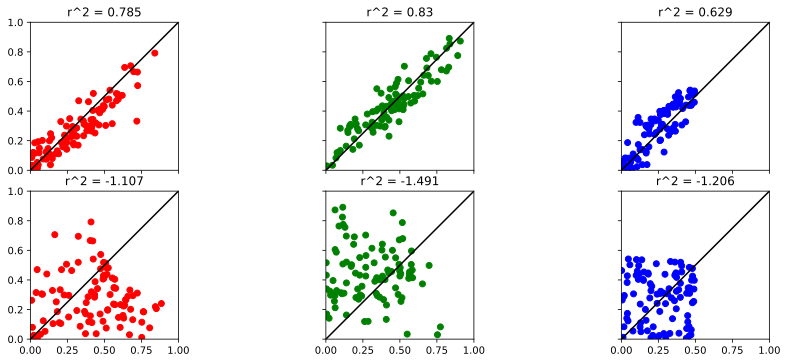

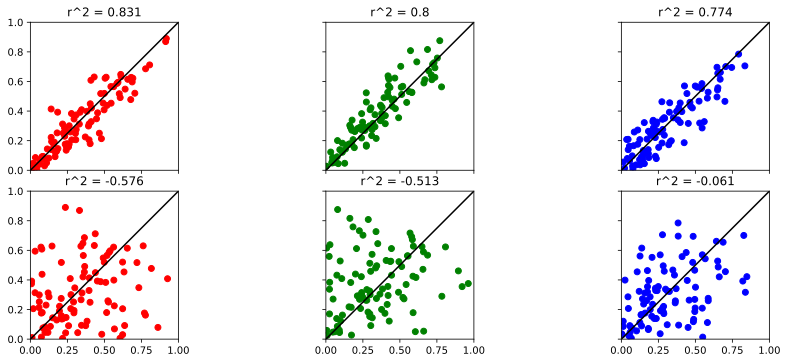

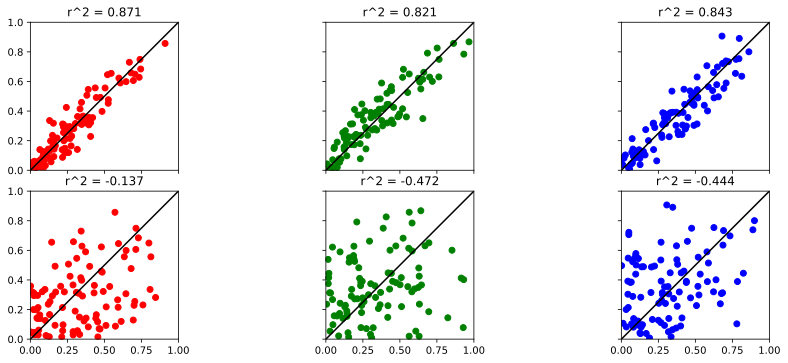

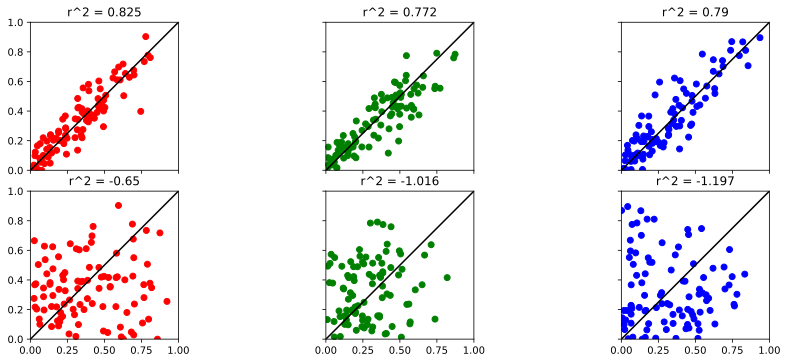

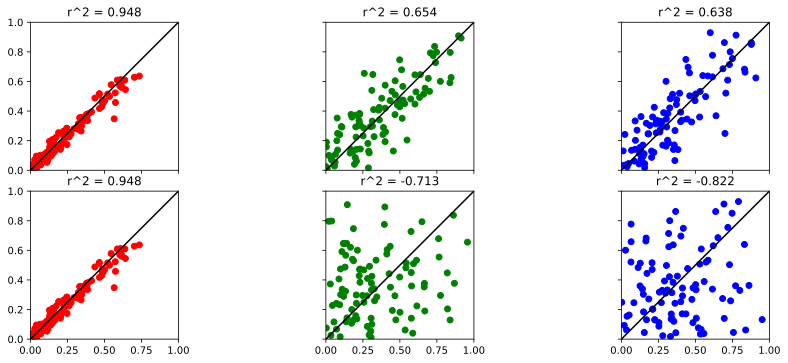

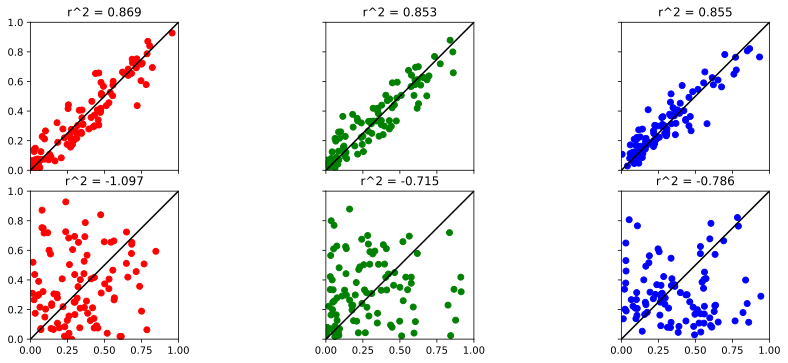

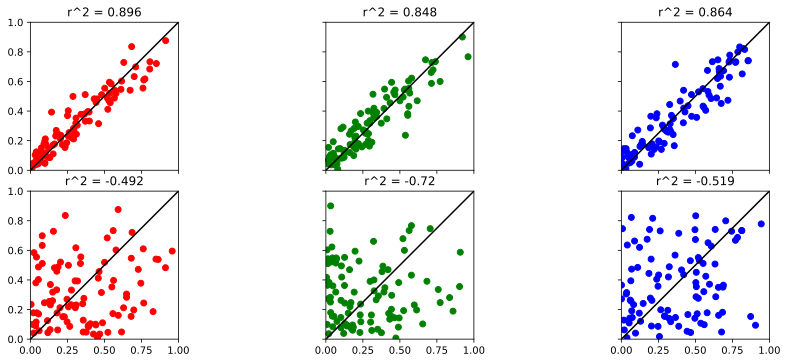

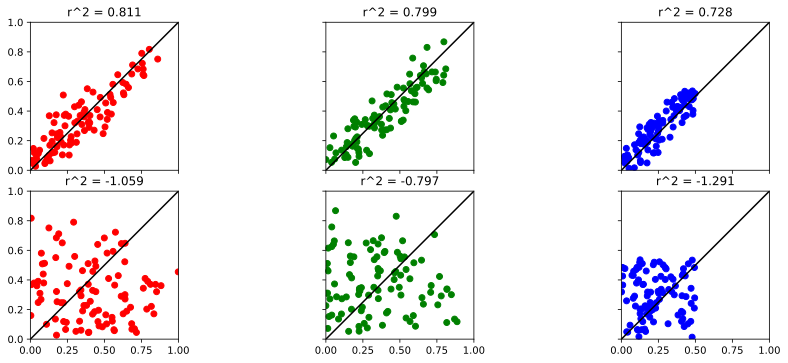

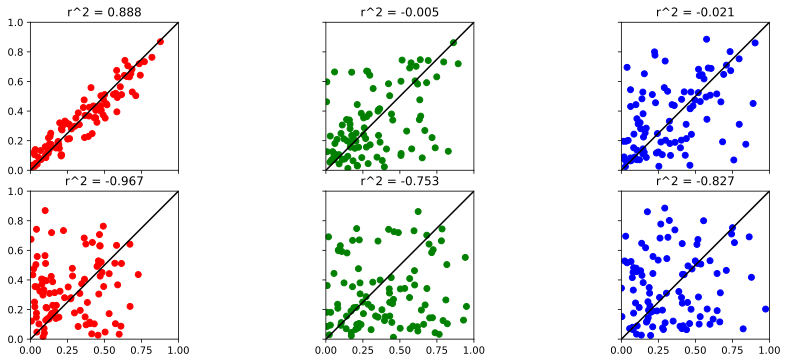

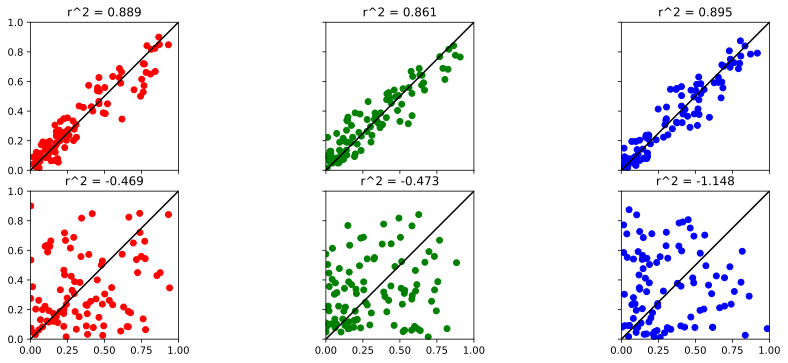

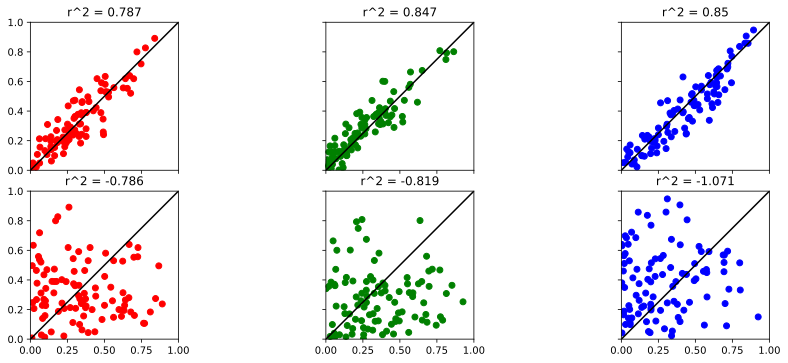

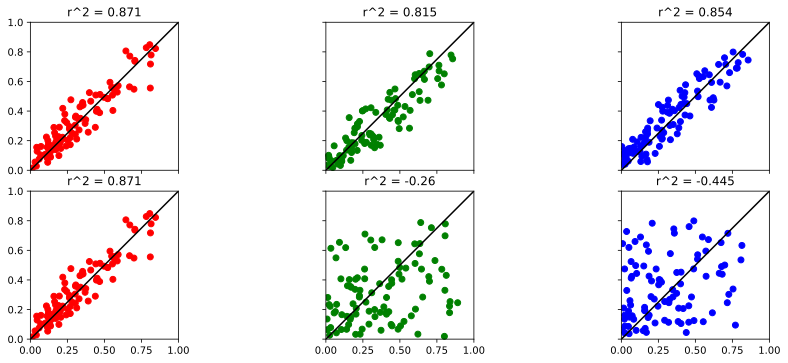

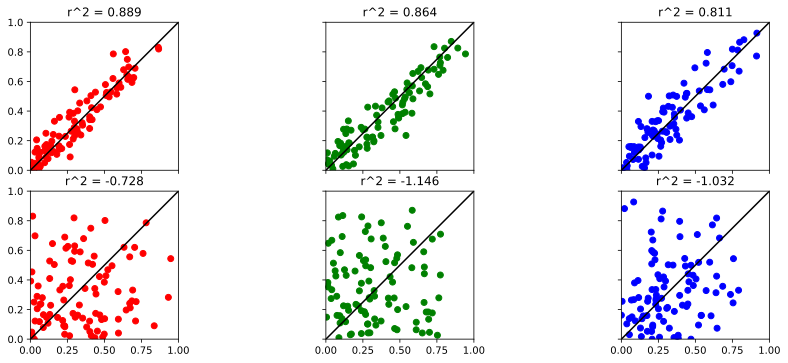

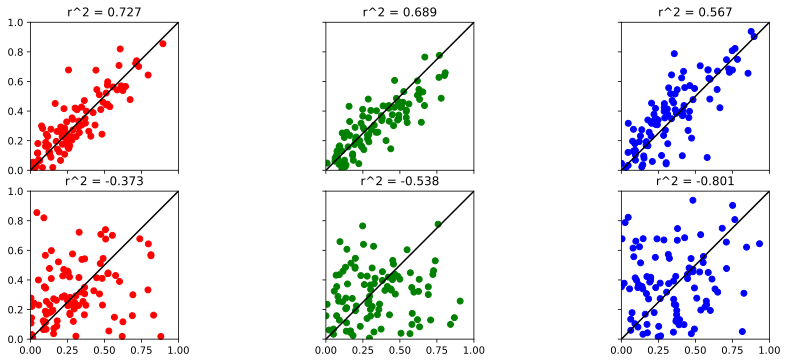

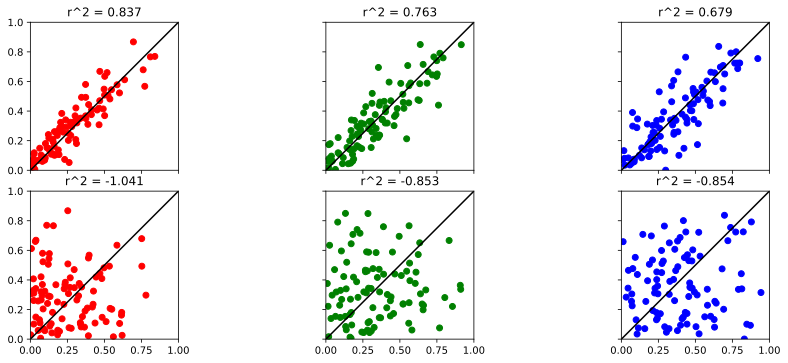

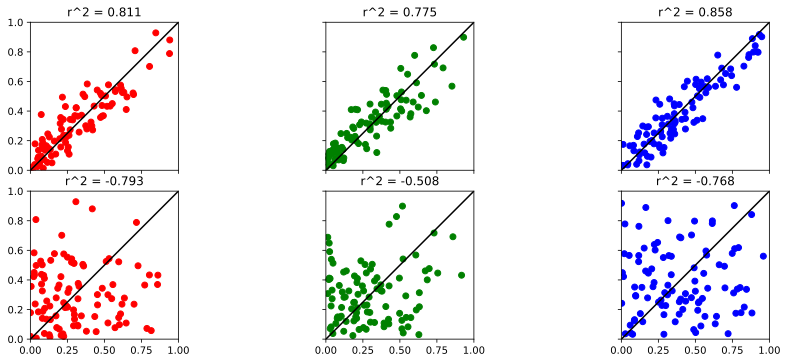

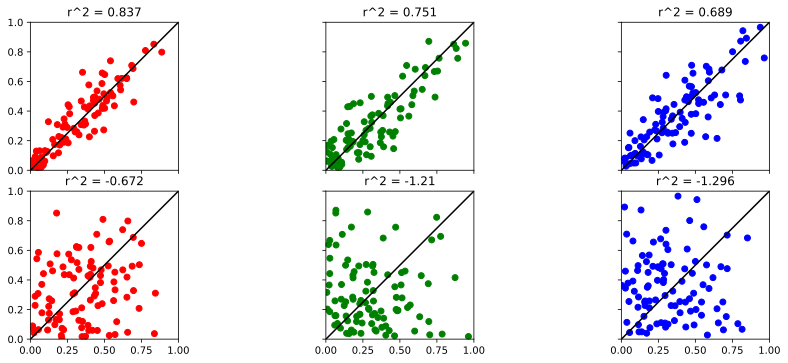

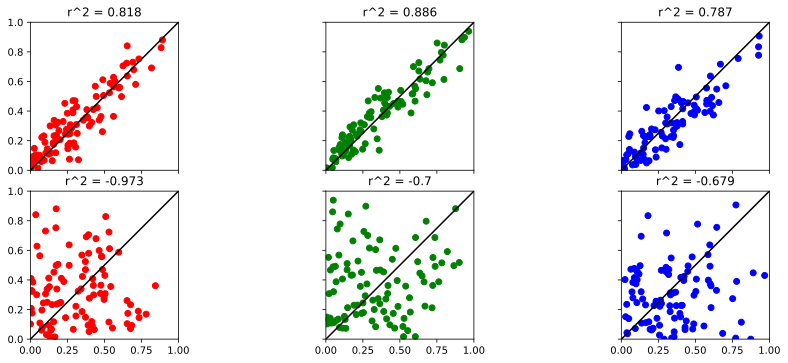

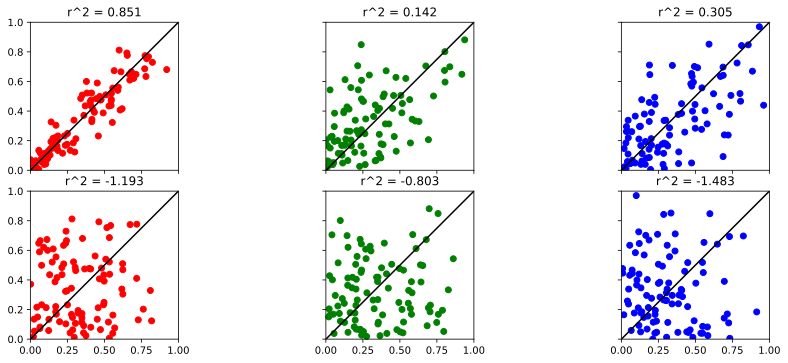

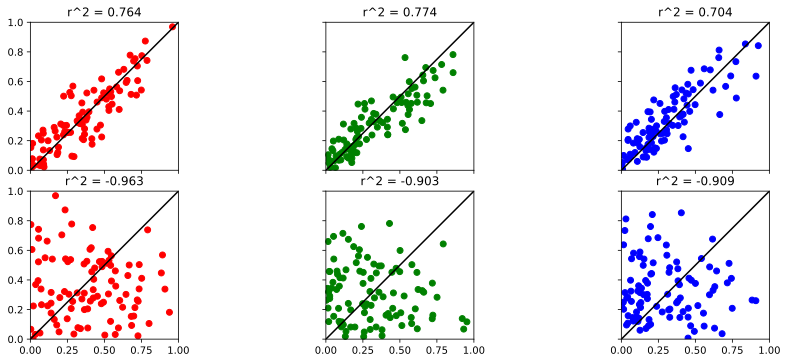

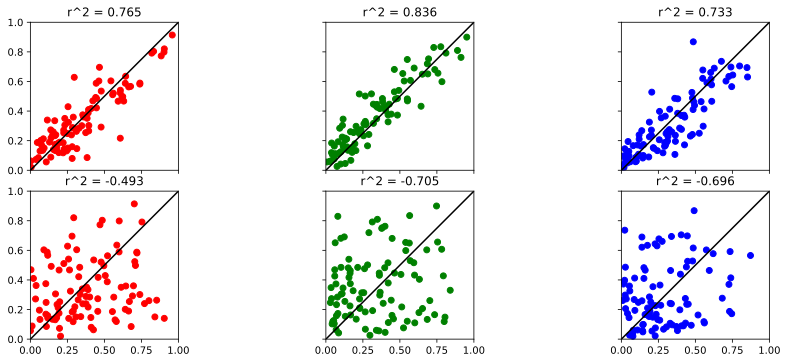

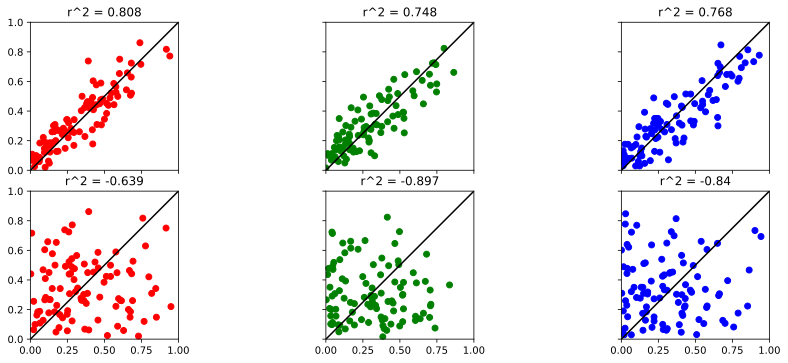

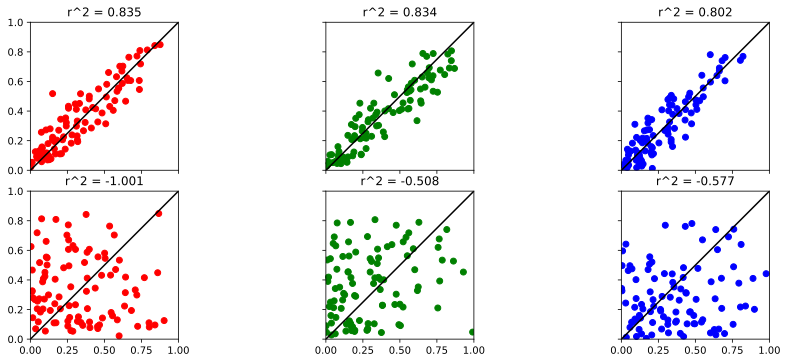

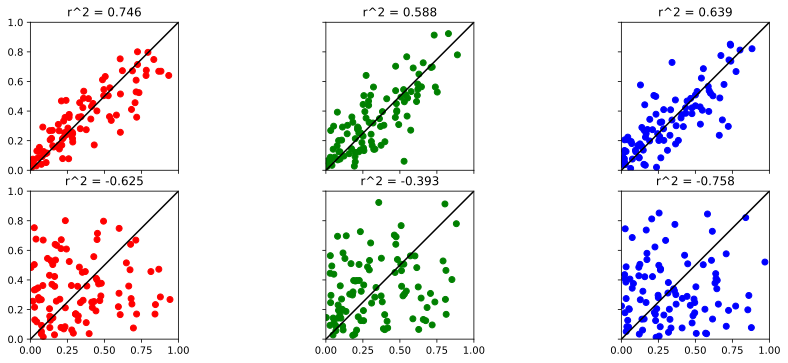

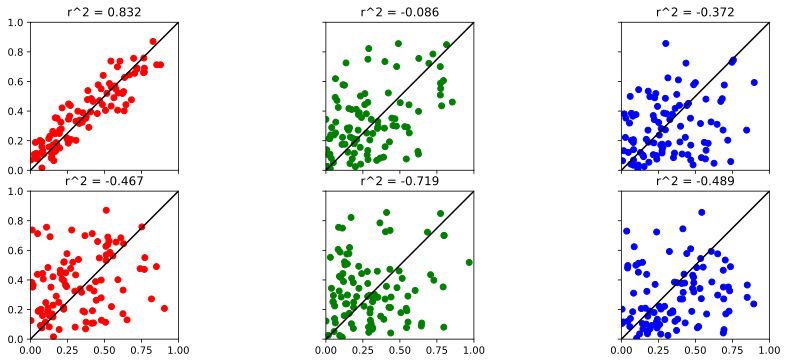

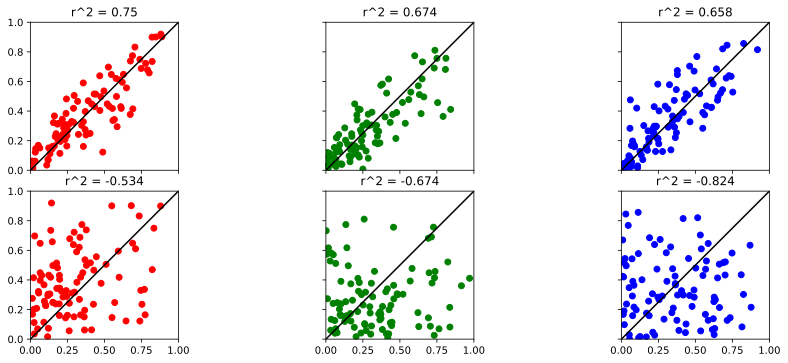

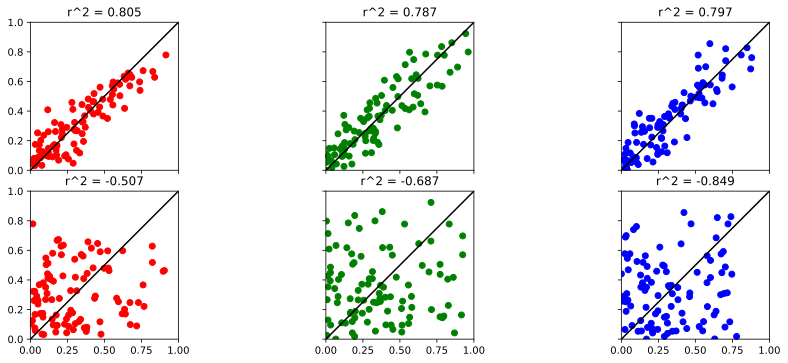

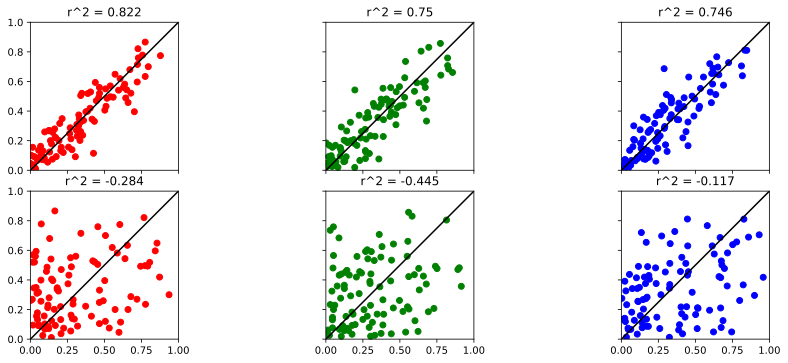

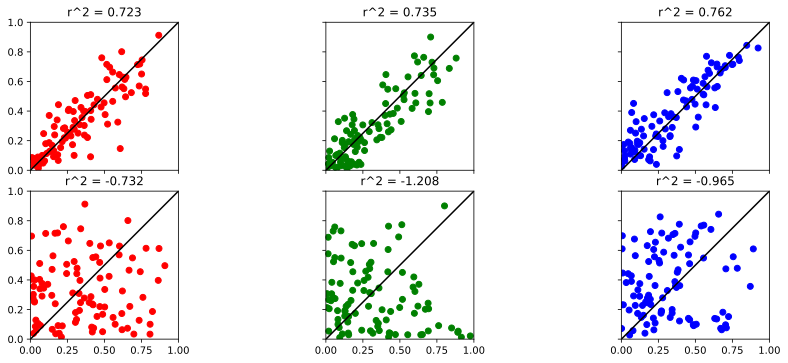

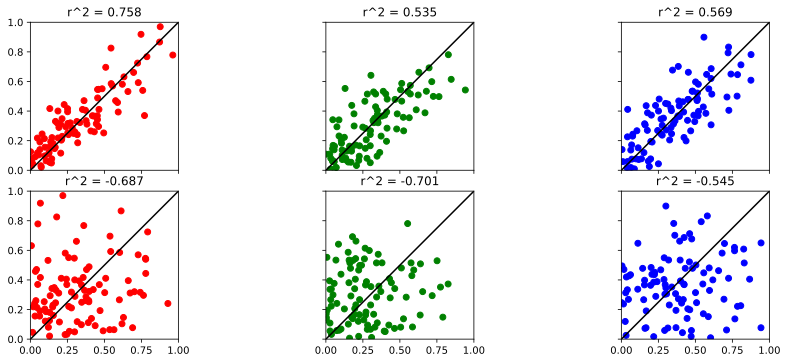

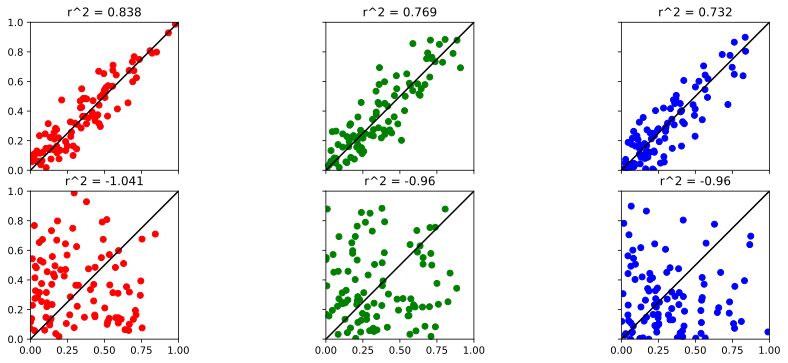

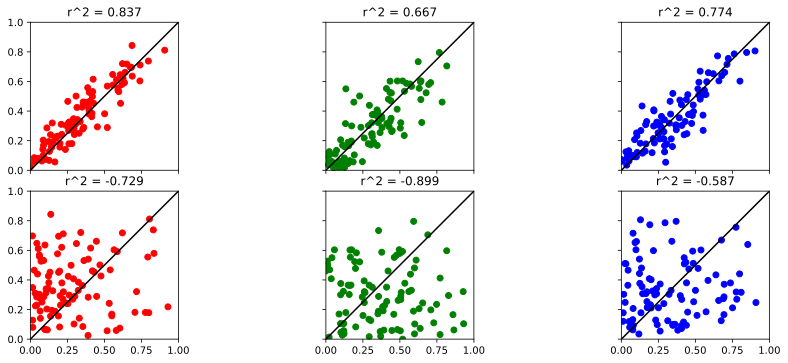

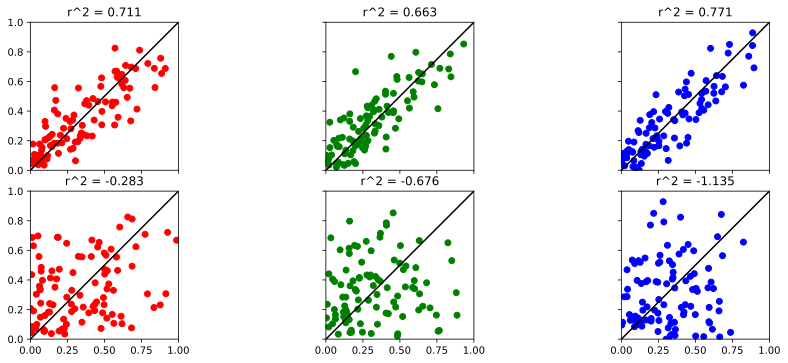

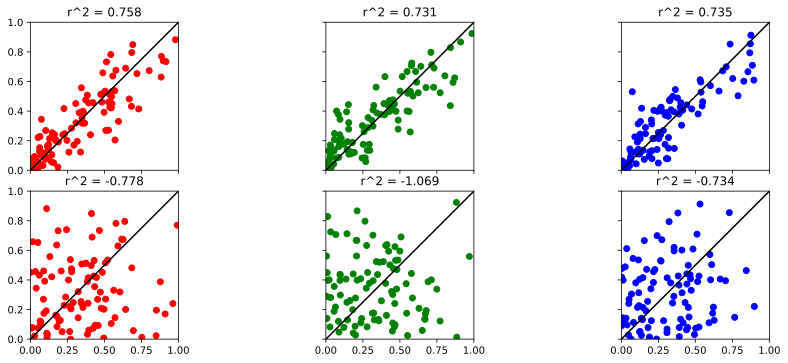

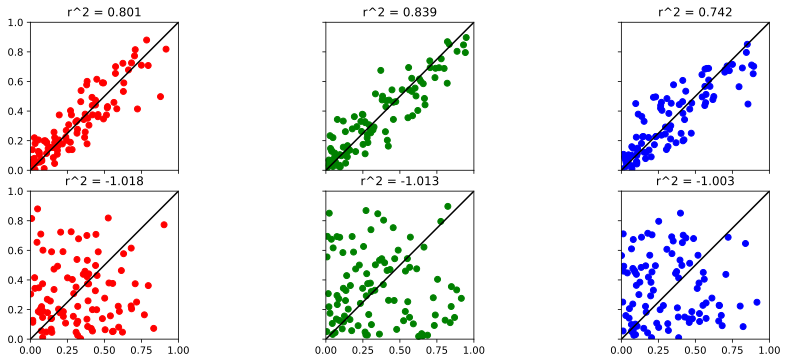

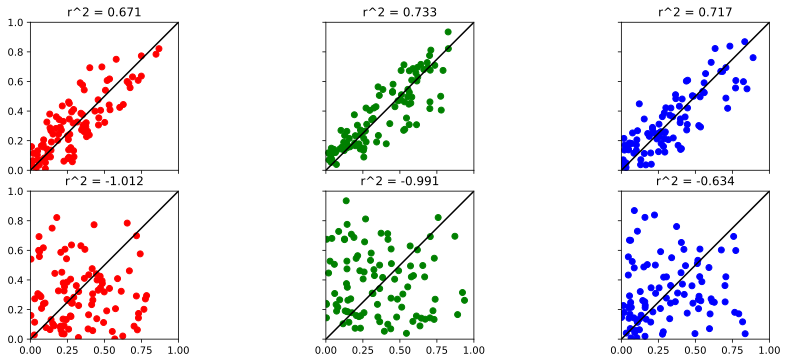

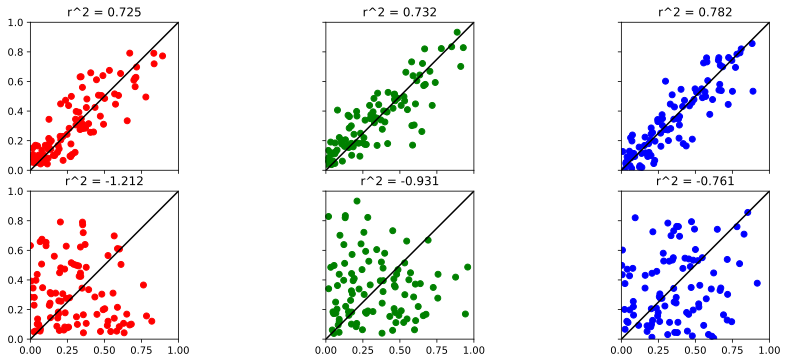

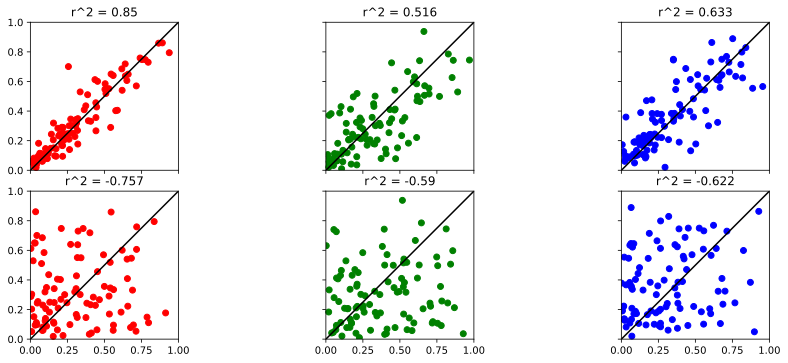

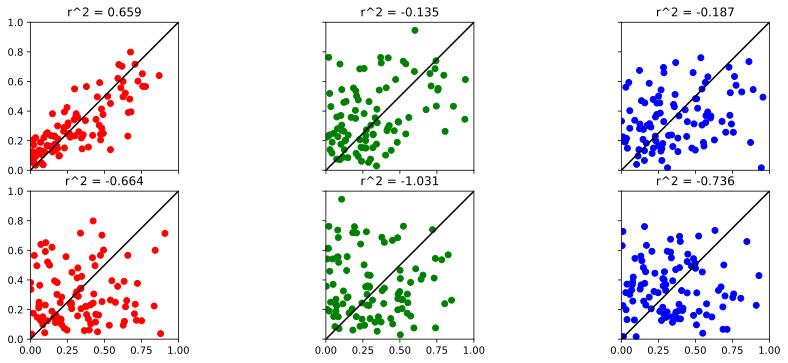

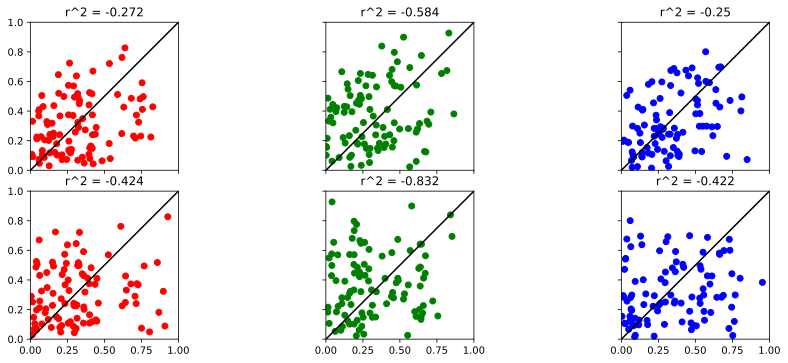

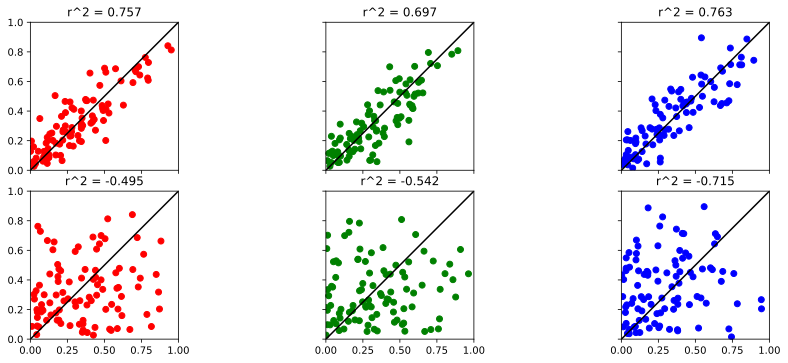

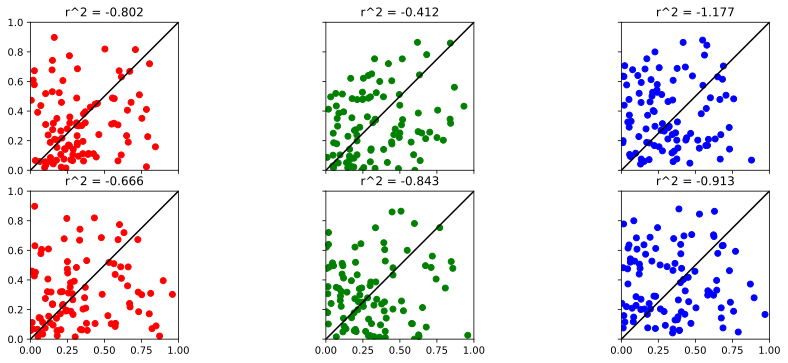

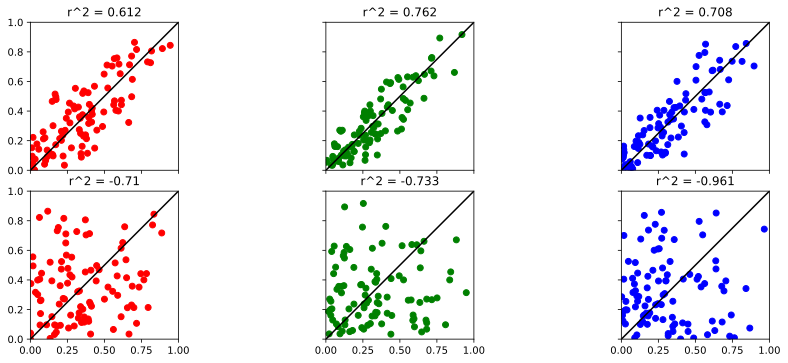

In [11]:
from tqdm import tqdm
num_data_points = len(job_id_arr)
alpha_arr = []
beta_arr = []
gamma_arr = []
r2_arr = []
r2_arr_0 = []
loss_arr = []
for index in range(num_data_points):
    print(f'Processing {index+1}/{num_data_points}', end='\r')
    pt_result = phase_tracking(job_id_arr[index], order_arr[index], yy, mm, dd)
    phi_arr = pt_result[0] 
    r2_arr.append(pt_result[1])
    r2_arr_0.append(pt_result[2])
    loss_arr.append(pt_result[3])
    alpha_arr.append(phi_arr[0])
    beta_arr.append(phi_arr[1])
    gamma_arr.append(phi_arr[2])

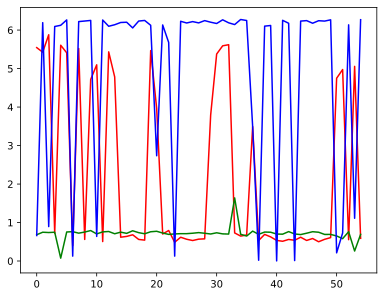

In [12]:
plt.plot(alpha_arr, color = 'r')
plt.plot(beta_arr, color = 'g')
plt.plot(gamma_arr, color = 'b')

In [17]:
r2_arr

[[-1.5714824436088245e+29, 0.744, 0.702],
 [0.934, 0.78, 0.757],
 [0.892, 0.895, 0.897],
 [0.883, 0.737, 0.801],
 [0.882, 0.817, 0.822],
 [0.829, 0.861, 0.805],
 [0.87, 0.884, 0.863],
 [0.868, 0.861, 0.869],
 [0.829, 0.81, 0.83],
 [0.892, 0.852, 0.871],
 [0.887, 0.86, 0.829],
 [0.884, 0.874, 0.716],
 [0.749, 0.844, 0.699],
 [0.825, 0.856, 0.825],
 [0.827, 0.827, 0.857],
 [0.838, 0.772, 0.804],
 [0.678, 0.782, 0.577],
 [0.825, 0.82, 0.841],
 [0.793, 0.835, 0.766],
 [0.898, 0.828, 0.825],
 [0.785, 0.831, 0.679],
 [0.843, 0.803, 0.797],
 [0.825, 0.781, 0.765],
 [0.861, 0.787, 0.808],
 [0.892, 0.731, 0.782],
 [0.723, 0.676, 0.765],
 [0.839, 0.724, 0.826],
 [0.834, 0.8, 0.808],
 [0.79, 0.794, 0.765],
 [0.897, 0.828, 0.812],
 [0.828, 0.859, 0.813],
 [0.688, 0.714, 0.73],
 [0.81, 0.788, 0.8]]

In [13]:
def normalized(arr):
    normalized_arr = []
    for phi in arr:
        normalized_phi = phi / (np.pi)
        if(normalized_phi > 1 - 0):
            normalized_arr.append(normalized_phi - 2)
        else:
            normalized_arr.append(normalized_phi)
    return normalized_arr

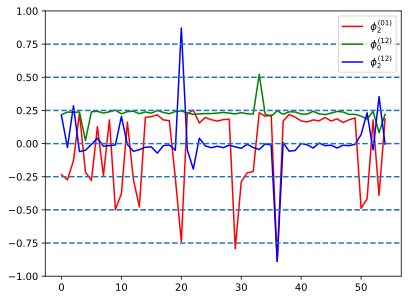

In [14]:
plt.plot(normalized(alpha_arr), color = 'r', label = '$\phi_2^{{(01)}}$')
plt.plot(normalized(beta_arr), color = 'g', label = '$\phi_0^{{(12)}}$')
plt.plot(np.array(normalized(gamma_arr)), color = 'b', label = '$\phi_2^{{(12)}}$')
plt.axhline(y = 0, linestyle='--')
plt.axhline(y = 0.25, linestyle='--')
plt.axhline(y = -0.25, linestyle='--')
plt.axhline(y = 0.75, linestyle='--')
plt.axhline(y = -0.75, linestyle='--')
plt.axhline(y = 0.5, linestyle='--')
plt.axhline(y = -0.5, linestyle='--')
plt.ylim(-1, 1)
plt.legend()

In [140]:
alpha_arr = normalized(alpha_arr)
beta_arr = normalized(beta_arr)
gamma_arr = normalized(gamma_arr)
[i for i, v in enumerate(gamma_arr) if v > 0.3]

[15, 23]

In [145]:
order_arr[15]

'1211112'

In [149]:
r2_arr[23]

[0.749, 0.833, 0.859]

In [146]:
order_arr[23]

'12111121'

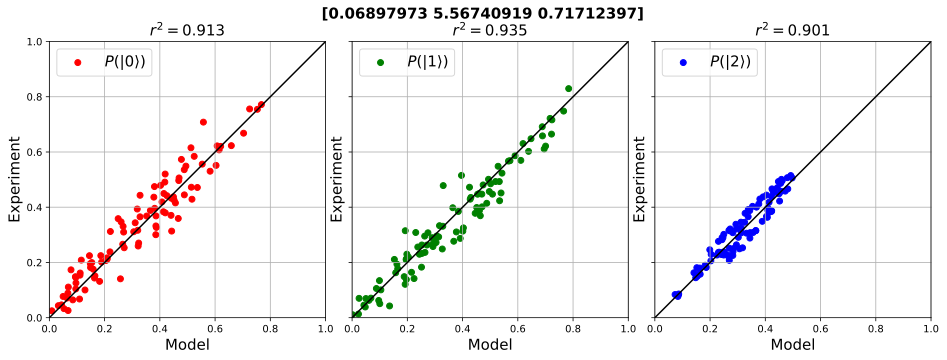

In [26]:
from sklearn.metrics import r2_score

N_data = 97
param = np.array(x_optimum)
model_population = [population_model(theta[i], phi[i], *param, order) for i in range(N_data)]

fig, axs = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(13, 5), dpi=100)
#fig, axs = plt.subplot_mosaic([[r'$|0\rangle$', r'$|1\rangle$', r'$|2\rangle$']])
plt.setp(axs.flat, aspect=1.0, adjustable='box')
# plt.subplots_adjust(top=1, hspace=0)
fig.tight_layout()
plt.suptitle(str(x_optimum), weight = 'bold', size=15)
#plt.suptitle(r'$\alpha=$'str(x_optimum[0]))
colors = ['r', 'g', 'b']

for i in range(3):
  p_model = [p[i] for p in model_population]
  #p_exp = [p[i] for p in popu_exp]
  p_exp = [p[i] for p in population]
  axs[i].scatter(p_model, p_exp, color = colors[i], label=fr'$P(|{i}\rangle)$')
  xplt = np.linspace(0, 1, 1000)
  axs[i].plot(xplt, xplt, color = 'black')
  axs[i].axis(xmin = 0, xmax = 1, ymin = 0, ymax = 1)
  axs[i].set_title(r'$r^2 = $' + str(np.round(r2_score(p_model, p_exp), 3)) , size=15)
  axs[i].set_xlabel('Model', size=15)
  axs[i].set_ylabel('Experiment', size=15)
  axs[i].grid()
  axs[i].legend(fontsize=15)